This code is an implementation of the below citation:

Dhanya, J., Raghukanth, S.T.G. Ground Motion Prediction Model Using Artificial Neural Network. Pure Appl. Geophys. 175, 1035–1064 (2018). https://doi.org/10.1007/s00024-017-1751-3

In [129]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score




In [3]:
# obtaining data
data = pd.read_csv("../../data/part1/data_reg.csv") #input
PSA_output = pd.read_csv("../../data/part1/PSA.csv") #output

In [4]:
# 20 periods in response spectrum
PSA_output.shape

(5079, 20)

In [18]:
# input variables 
data.columns

Index(['Rup', 'M', 'R', 'log(R)', 'log(VS30)', 'focal_mech', 'PGA'], dtype='object')

In [75]:
X = data[['Rup', 'M', 'R', 'log(R)', 'log(VS30)', 'focal_mech']]
y = PSA_output

In [76]:
# scaling and fitting the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [98]:
# defining the network
class ShallowNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 5)   # Input layer to hidden layer with 64 neurons
        self.fc2 = nn.Linear(5, output_size)  # Hidden layer to output layer with 20 neurons

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [99]:
# model setup
input_size = X_train.shape[1]
output_size= y_train.shape[1]
model = ShallowNet(input_size, output_size)

In [101]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [102]:
train_losses = []

In [103]:
# Training
epochs = 3000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())



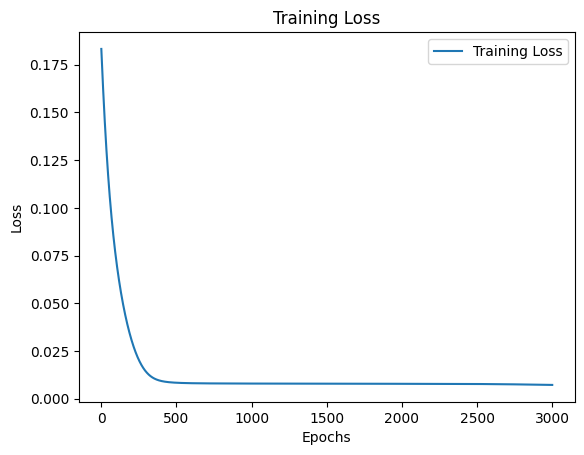

In [104]:
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [105]:
#Evaluate 
with torch.no_grad():
    model.eval()
    predicted = model(X_test_tensor).detach().numpy()


In [130]:
mse = mean_squared_error(y_test, predicted)
print(f"Mean square error: {mse}")

r2 = r2_score(y_test, predicted)
print(f"R2 Score: {r2}")

Mean square error: 0.008105370493387722
R2 Score: -5.406171463022065


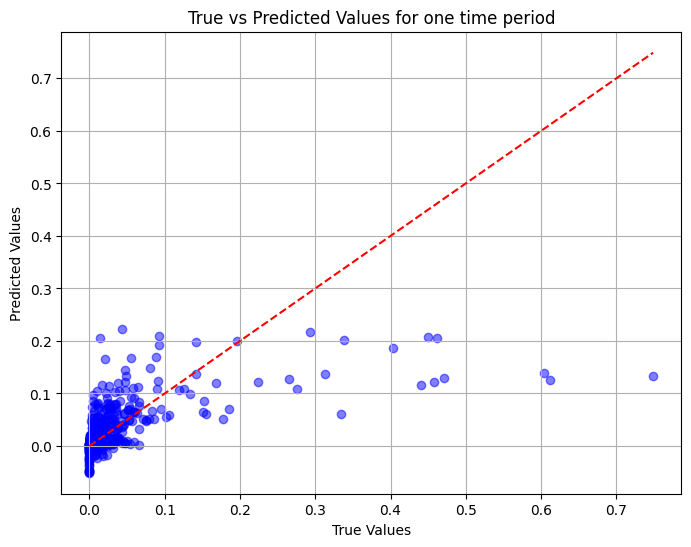

In [131]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test["0.01"], predicted[:,0], color='blue', alpha=0.5)
plt.plot([min(y_test["0.01"]), max(y_test["0.01"])], [min(y_test["0.01"]), max(y_test["0.01"])], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for one time period')
plt.grid(True)
plt.show()

In [132]:
period = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.12, 0.15, 0.17, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1, 2, 3, 4]

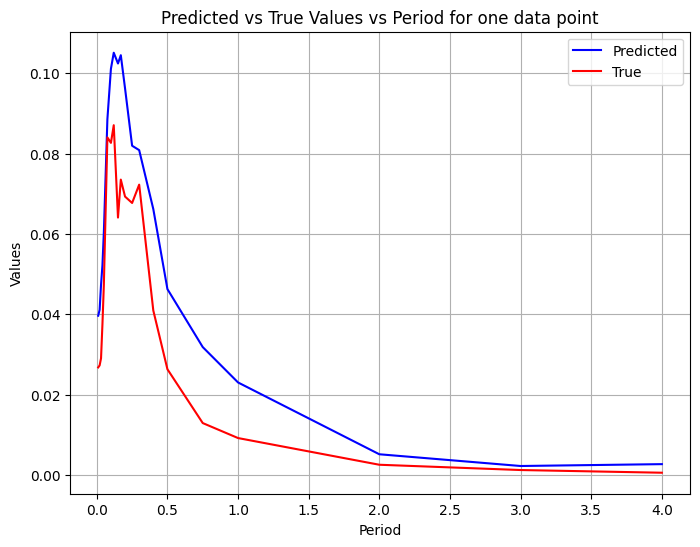

In [133]:
plt.figure(figsize=(8, 6))
plt.plot(period, predicted[0], label='Predicted', color='blue')
plt.plot(period, y_test.iloc[0], label='True', color='red')
plt.xlabel('Period')
plt.ylabel('Values')
plt.title('Predicted vs True Values vs Period for one data point')
plt.legend()
plt.grid(True)
plt.show()